# Feature Extraction: HOG

## Setup

In [2]:
!pip install webdataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.3 MB/s eta 0:00:00


In [36]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np

from skimage import feature
from skimage import data, exposure
from skimage import filters

In [5]:
# paths
root = '/content/drive'
data_folder = f'{root}/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main/data'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main')

Mounted at /content/drive


## Load Data

In [6]:
def load_data(path_to_data):
    """
    load 2D images and their labels

    returns:
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []
    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
            .decode("pil").to_tuple("jpg", "json"))
    #iterate dataset
    data_iter = iter(data)
    #append dataset to lists
    for row in data_iter:
        image = np.array(row[0])
        label = row[1]['label']
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()
    return images, labels

In [7]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


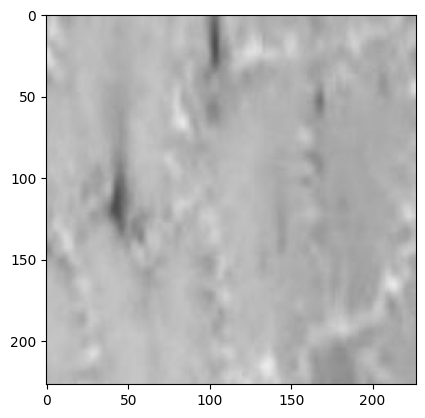

In [8]:
print(train_labels[0])
plt.imshow(train_images[0])

In [9]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8960, 227, 227, 3)
Shape of labels: (8960,)


## Quick EDA

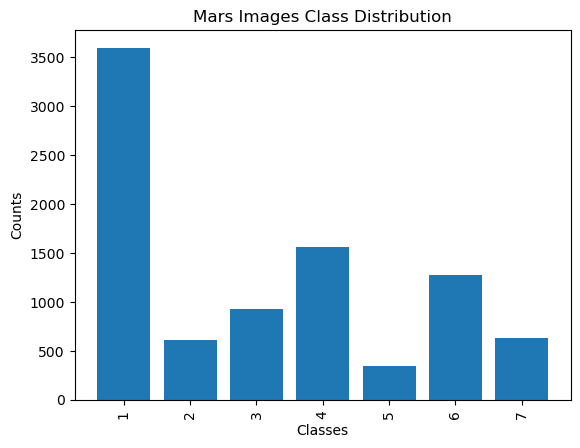

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

{1: 7, 2: 448, 3: 602, 4: 2478, 5: 35, 6: 1407, 7: 0}


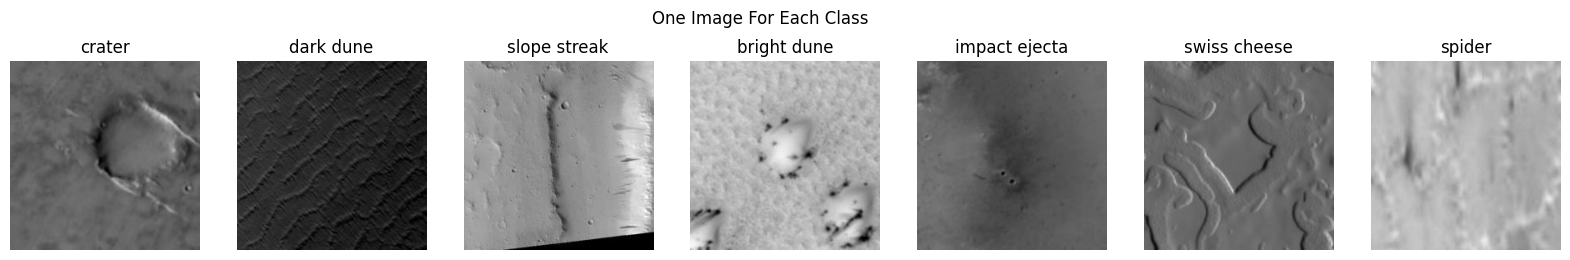

In [10]:
#show example of 1 of each class
label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
result = {}
unique_values = np.unique(train_labels)
for value in unique_values:
    indices = np.where(train_labels==value)[0][:1]
    result[value] = np.int_(indices)[0]
print(result)
#plotting first image for each class
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    #label_name = label_names[label]
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('One Image For Each Class')
plt.show()

## Feature Extraction: Edge Detection


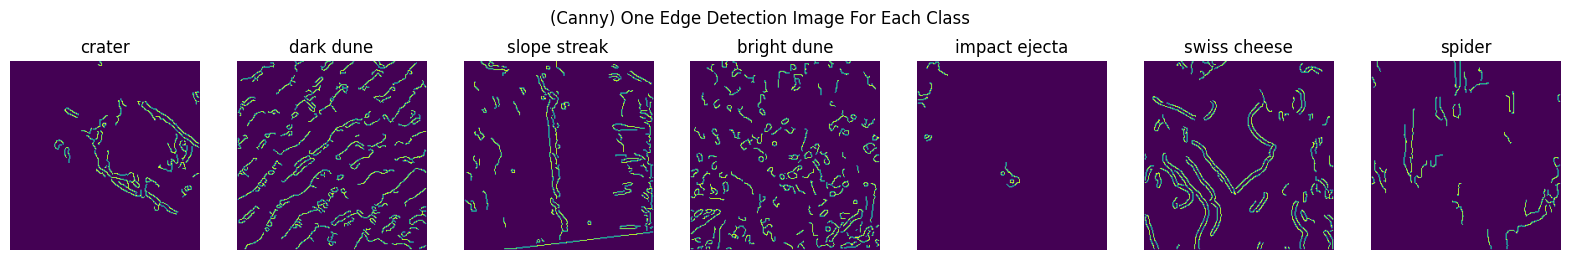

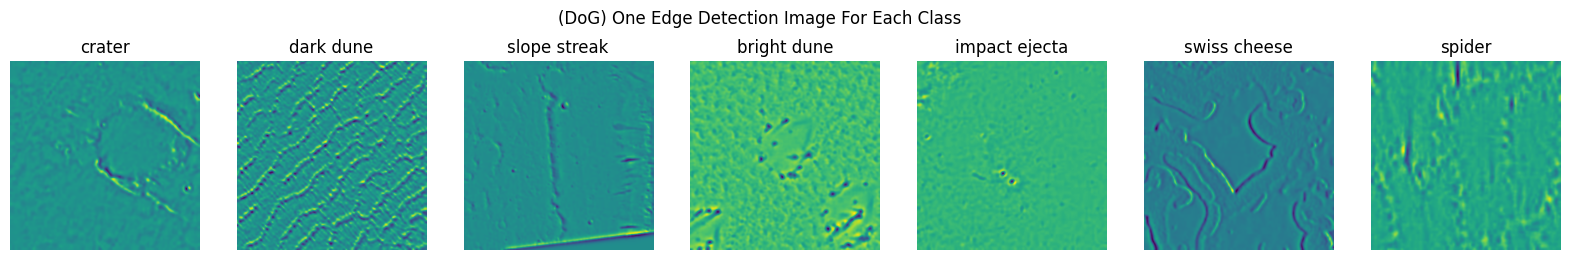

In [38]:
#start with 1 example for each class for visualization, for each method
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    # To Do - Decide between edges detection Canny vs Difference of Gaussians
    canny_edges_image = feature.canny(image[:,:,0], sigma = 1.3) # Canny Edge Detection, requires 2-D matrix - Higher sigma = more blur/less noise, Lower sigma = less blue/more noise
    axs[i].imshow(canny_edges_image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('(Canny) One Edge Detection Image For Each Class')
plt.show()

 #start with 1 example for each class for visualization, for each method
fig, axs = plt.subplots(nrows=1, ncols=len(result), figsize=(20,3))
i = 0
for key, value in result.items():
    image = train_images[value]
    label = label_names[key-1]
    # To Do - Decide between edges detection Canny vs Difference of Gaussians
    dog_edges_image = filters.difference_of_gaussians(image[:,:,0], low_sigma = 1, high_sigma = 3) # Canny Edge Detection, requires 2-D matrix - Higher sigma = more blur/less noise, Lower sigma = less blue/more noise
    axs[i].imshow(dog_edges_image)
    axs[i].set_title(label)
    axs[i].axis('off')
    i += 1
fig.suptitle('(DoG) One Edge Detection Image For Each Class')
plt.show()

In [40]:
#apply to all
def extract_edges_canny(img_dataset, sigma = 1.0):
    """
    Apply Canny edge detection for feature extraction to all images
    args: img_dataset (training / val / testing dataset)
    returns: img_dataset_canny_edges (dataset of canny edges)
    """
    img_dataset_canny_edges = []
    for img in img_dataset:
        canny_edges_image = feature.canny(image[:,:,0], sigma = 1.3)
        img_dataset_canny_edges.append(canny_edges_image)
    img_dataset_canny_edges = np.array(img_dataset_canny_edges)
    return img_dataset_canny_edges

In [43]:
train_images_canny_edges = extract_edges_canny(train_images, sigma = 1.3)
val_images_canny_edges = extract_edges_canny(val_images, sigma = 1.3)
test_images_canny_edges = extract_edges_canny(test_images, sigma = 1.3)

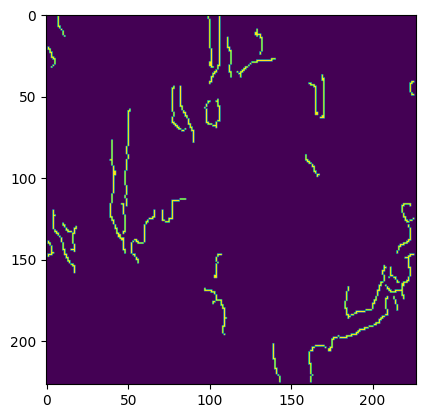

In [45]:
plt.imshow(train_images_canny_edges[0])